In [1]:
# imports
from octis.models.ETM import ETM
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.optimization.optimizer import Optimizer
optimizer=Optimizer()
import time
import en_core_web_sm
nlp = en_core_web_sm.load()
dataset = Dataset()
dataset.load_custom_dataset_from_folder("pre_Flower_stop")
docs = [" ".join(words) for words in dataset.get_corpus()]

/sw/arch/RHEL8/EB_production/2022/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
model = ETM(num_topics=10)

search_space = {
    "activation": Categorical(["relu", "softplus", "tanh"]),  # Activation function
    "dropout": Real(0.0, 0.5),  # Dropout rate
    "t_hidden_size": Integer(100, 1000),  # Size of hidden layer in the encoder
    "alpha": Real(1e-5, 1e-2, prior='log-uniform')  # Regularization parameter
}

In [3]:
#SETTING METRICS
coherence = Coherence(texts=dataset.get_corpus(), measure = 'c_v')
diversity = TopicDiversity(topk=10)

In [4]:
#RUN CONFIGURATION
optimization_runs=10
model_runs=2

In [5]:
#OPTIMIZATION
start = time.time()
optimization_result = optimizer.optimize(
    model, dataset, coherence, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=[diversity], # to keep track of other metrics
    save_path='results/test_ETM2//')
end = time.time()
duration = end - start
optimization_result.save_to_csv('results_ETM2.csv')
print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

Current call:  0
model: ETM(
  (t_drop): Dropout(p=0.4927880253307994, inplace=False)
  (theta_act): Softplus(beta=1, threshold=20)
  (rho): Linear(in_features=300, out_features=150398, bias=False)
  (alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=150398, out_features=276, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=276, out_features=276, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
  (mu_q_theta): Linear(in_features=276, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=276, out_features=10, bias=True)
)
Epoch: 1 .. batch: 20/105 .. LR: 0.005 .. KL_theta: 1.34 .. Rec_loss: 545.09 .. NELBO: 546.43
Epoch: 1 .. batch: 40/105 .. LR: 0.005 .. KL_theta: 0.69 .. Rec_loss: 519.56 .. NELBO: 520.25
Epoch: 1 .. batch: 60/105 .. LR: 0.005 .. KL_theta: 0.46 .. Rec_loss: 511.29 .. NELBO: 511.75
Epoch: 1 .. batch: 80/105 .. LR: 0.005 .. KL_theta: 0.35 .. Rec_loss: 506.0

In [6]:
optimizer = Optimizer()
json_path = 'results/test_ETM2/result.json'
optimizer.resume_optimization(json_path)

In [7]:
import json
results = json.load(open("results/test_ETM2/result.json",'r'))
results.keys()

dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

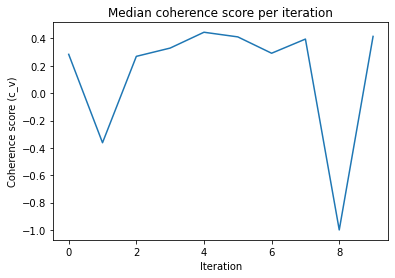

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.show()

In [9]:
results[ 'f_val'].index(max(results[ 'f_val']))

4

In [10]:
print([results['x_iters'][parameter][0] for parameter in results['x_iters'].keys()])

['softplus', 0.0011406094161725707, 0.4927880253307994, 276]
